## **Model Interpretability**
In this notebook, i trained logistic regression model, xgboost classifer and automl model(using h2o) and compare shap interpretability and basic interpret corfficients and nodes.

Analysis the shap summary beeswarm plot, the important fearute 'caa' and 'cp' and their effect direction on prediction be more understandable. The shap is more interpretable and intuitive. 

### Import libraries and dataset

In [ ]:
!pip install shap h2o

In [3]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

In [149]:
#Reading the HeartAttack data
df=pd.read_csv("/content/drive/MyDrive/heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [7]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Data processing

In [150]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
#df = pd.get_dummies(df, columns = cat_cols)
y=df["output"]
X = df.drop(columns=["output"])




In [86]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
# scaling the continuous featuree
cont_cols = ["age","trtbps","chol","thalachh","oldpeak"]
X[cont_cols] = scaler.fit_transform(X[cont_cols])


In [63]:
df.head()

,age,trtbps,chol,thalachh,oldpeak,output,sex_0,sex_1,exng_0,exng_1,...,restecg_0,restecg_1,restecg_2,slp_0,slp_1,slp_2,thall_0,thall_1,thall_2,thall_3
0,63,145,233,150,2.3,1,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,1,1,0,1,0,...,1,0,0,0,0,1,0,0,1,0
3,56,120,236,178,0.8,1,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,57,120,354,163,0.6,1,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [151]:
#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### Model training and basic interpret
#### Linear model: Logistic regression

In [152]:
#Create Logistic regression object
logit = LogisticRegression(random_state= 0)
# Train the model using the training sets
logit.fit(X_train, y_train)
# Make predictions using the testing set
logit_pred = logit.predict(X_test)

print("The test accuracy score of Logistric Regression is ", metrics.accuracy_score(y_test, logit_pred))


The test accuracy score of Logistric Regression is  0.8852459016393442


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [153]:
coeff = pd.DataFrame(logit.coef_, columns=X_train.columns)
coeff.T

,0
age,0.007977
sex,-1.201236
cp,0.775158
trtbps,-0.010961
chol,-0.001412
fbs,-0.001505
restecg,0.535762
thalachh,0.027077
exng,-0.829122
oldpeak,-0.676467


In [15]:
import statsmodels.api as sm
#sklearn does not have a built in method to calculate p-values so here using statsmodel summary method to get p-value
model = sm.Logit(y_train, X_train).fit()

# Print out the statistics
model.summary()

Optimization terminated successfully.
         Current function value: 0.361202
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                  242
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                           12
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                  0.4752
Time:                        16:12:39   Log-Likelihood:                -87.411
converged:                       True   LL-Null:                       -166.55
Covariance Type:            nonrobust   LLR p-value:                 1.178e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.1125      0.332     -0.339      0.735      -0.763       0.538
sex           -1.6684      0.501     -3.327      0.001      -2.651      -0.686
cp             0.9697      0.206      4.716      0.000       0.567       1.373
trtbps        -0.3558      0.234     -1.521      0.128      -0.815       0.103
chol          -0.2148      0.258     -0.832      0.405      -0.721       0.291
fbs            0.5989      0.619      0.967      0.333      -0.614       1.812
restecg        0.6813      0.386      1.767      0.077      -0.074       1.437
thalachh       0.5009      0.386      1.299      0.194      -0.255       1.257
exng          -1.0138      0.453     -2.239      0.025      -1.901      -0.127
oldpeak       -0.8690      0.389     -2.234      0.025      -1.631      -0.107
slp            1.2542      0.338      3.710      0.000       0.592       1.917
caa           -0.8731      0.229     -3.818      0.000      -1.321      -0.425
thall         -0.3928      0.241     -1.627      0.104      -0.866       0.080
==============================================================================
"""

In [16]:
logit_pred = model.predict(X_test)
logit_pred = list(map(round, logit_pred))
print("The test accuracy score of Logistric Regression is ", metrics.accuracy_score(y_test, logit_pred))


The test accuracy score of Logistric Regression is  0.819672131147541


From the coefficients and p-value, the feature 'cp'(i.e. Chest Pain type chest pain type) which has p-value 0.0 and coefficient value be 0.8592, 'caa'(number of major vessels (0-3)) which has p-value 0.0 and coefficient value be -0.8427 should be top importance.An increase of 1 in 'cp' multiplies the odds of not having heart attack by 0.8592. An increase of 1 in 'caa' is associated with an decrease of 0.8427 in the odds of not having heart disease.

#### Tree based model: XGBoost classifier

In [114]:
#Create XGBoost model
xgb = XGBClassifier(learning_rate=0.01,max_depth=10)
#Train with training sets
xgb.fit(X_train, y_train)
#Make predictions
xgb_pred = xgb.predict(X_test)

print("The test accuracy score of XGBoost is ", metrics.accuracy_score(y_test, xgb_pred))

The test accuracy score of XGBoost is  0.8524590163934426


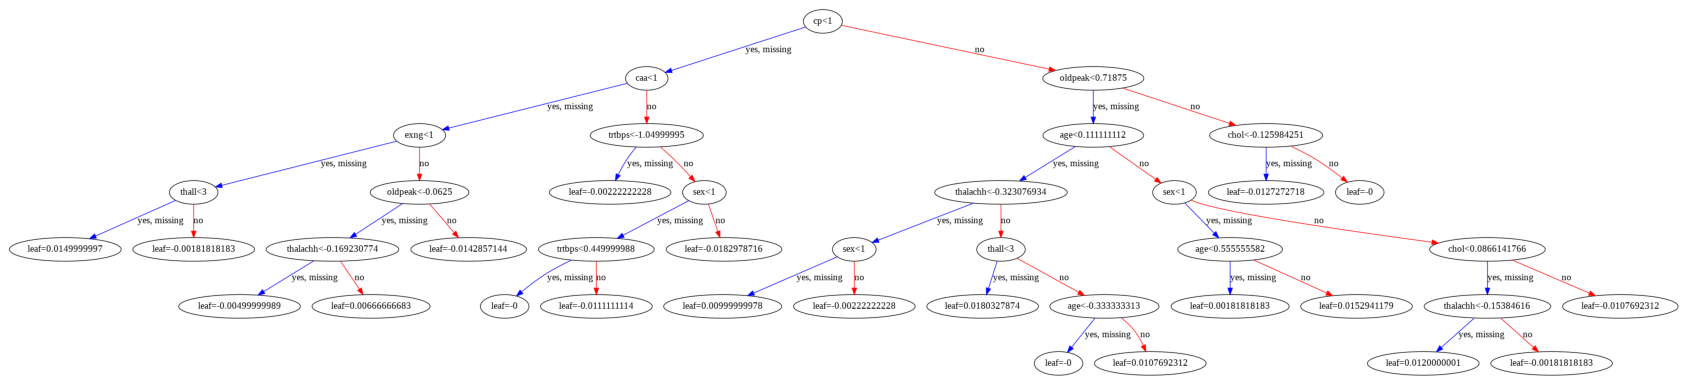

In [115]:
import xgboost
from sklearn import tree
fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(xgb, ax=ax)
plt.show()

From the tree plot, the first partition of the samples into 2 groups was made by comparing the value of 'cp'
 with 1, then consider the value of 'caa' and 'oldpeak' to continue partition. Following the tree deeper depth nodes partition according to feature and value. 

#### AutoML in H2O

In [19]:
#init h2o with parameters
target='output'
min_mem_size=6 
run_time=222
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
# 65535 Highest port no
port_no=random.randint(5555,55555)
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:27591 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp56i0j4f7
  JVM stdout: /tmp/tmp56i0j4f7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp56i0j4f7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:27591
Connecting to H2O server at http://127.0.0.1:27591 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_wta0zm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [20]:
# upload data frame in H2O environment
df_h2o = h2o.H2OFrame(df)
x = df_h2o.columns
x.remove(target)
train, test = df_h2o.split_frame(ratios=[0.8])
train['output'] = train['output'].asfactor()
test['output'] = test['output'].asfactor()
# Run AutoML for 20 base models (limited to 1 hour max runtime by default) h2o shap only implement for treemodel and others
aml = H2OAutoML(max_models=20, seed=11,exclude_algos = ['DeepLearning','glm'])#so here exclude glm model
aml.train(x=x, y=target, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
16:12:55.215: GBM_1_AutoML_1_20221205_161251 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20221205_161251.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 189.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 189.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 190.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 190.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must hav

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20221205_161251_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    57                 57                          9733                   3            7            4.54386       5             11            8.94737

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05205835139437565
RMSE: 0.228162993043078
LogLoss: 0.2036375407113103
Mean Per-Class Error: 0.042595255212077646
AUC: 0.9873472322070453
AUCPR: 0.9880272327628552
Gini: 0.9746944644140907

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5515430223744339
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      102  5    0.0467   (5.0/107.0)
1      5    125  0.0385   (5.0/130.0)
Total  107  130  0.0422   (10.0/237.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.551543     0.961538  128
max f2                       0.330433     0.971599  147
max f0point5                 0.597227     0.96395   125
max accuracy                 0.551543     0.957806  128
max precision                0.993193     1         0
max recall                   0.330433     1         147
max specificity              0.993193     1         0
max absolute_mcc             0.551543     0.914809  128
max min_per_class_accuracy   0.565334     0.953271  127
max mean_per_class_accuracy  0.551543     0.957405  128
max tns                      0.993193     107       0
max fns                      0.993193     129       0
max fps                      0.00583385   107       235
max tps                      0.330433     130       147
max tnr                      0.993193     1         0
max fnr                      0.993193     0.992308  0
max fpr                      0.00583385   1         235
max tpr                      0.330433     1         147

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.85 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0126582                   0.984659           1.82308   1.82308            1                0.987893   1                           0.987893            0.0230769       0.0230769                  82.3077   82.3077            0.0230769
2        0.021097                    0.98258            1.82308   1.82308            1                0.983687   1                           0.98621             0.0153846       0.0384615                  82.3077   82.3077            0.0384615
3        0.0337553                   0.981273           1.82308   1.82308            1                0.981875   1                           0.984585            0.0230769       0.0615385                  82.3077   82.3077            0.0615385
4        0.0421941                   0.977674           1.82308   1.82308            1                0.979744   1                           0.983616            0.0153846       0.0769231                  82.3077   82.3077            0.0769231
5        0.0506329                   0.975938           1.82308   1.82308            1                0.976471   1                           0.982426   

In [21]:
h2olb = aml.leader 
aml_pred = h2olb.predict(test)
print(h2olb.algo)
print("The mean test accuracy score of AutoML h2o leader model is ", (aml_pred["predict"] == test["output"]).mean())

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm
The mean test accuracy score of AutoML h2o leader model is  [0.8333333333333334]


### Model Interpretation with SHAP

In [154]:
#create linear explainer to calculate shap values for logit model
logitExplainer = shap.LinearExplainer(logit,X_train)
logit_shap_values = logitExplainer.shap_values(X_test)
shap.initjs()
shap.force_plot(logitExplainer.expected_value, logit_shap_values[2:3], X_test[2:3])#choose and show a single prediction

In [147]:
y_test.iloc[2]

1

For this person, their prediction is 1.54 (compared to a baseline of -0.1164)and more likely to have heart attack. Not working in their favour are things like having no exercise induced angina'exng',a low 'oldpeak' and low 'chol', a downsloping 'slp', a non-anginal pain 'cp'(chest pain type), and a fast boold sugar 'fbs'.Biggest impact comes from cp = 2(non-anginal chest pain type), Though the thall value =3(i.e. thalassemia reversable defect) has a meaningful effect decreasing the prediction.

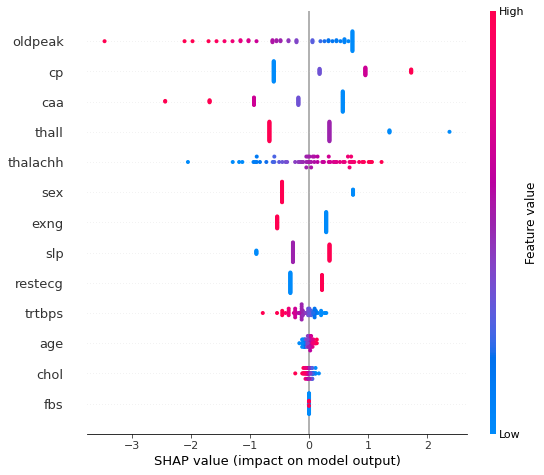

In [155]:
shap.summary_plot(logit_shap_values, X_test)

From this shap summary plot,we can not only observe the feature importance but also their effect direction on shap values.<br/>
In general, 'cp' is most important among these features and lower value lead more probability to not having heart attack. 
Followed with 'caa' and 'oldpeak', the higher 'caa' value the higher probability patient have heart attack.
And observe the distribution of 'oldpeak', instance of higher oldpeak extend further towards the left, suggesting high oldpeak has stronger negative impact to make a having  heart attack prediction than the positive impact of lower oldpeak. <br/>
Check the bottom instance distribution of 'fbs' , the 'fbs' feature has almost no influence upon shap output.

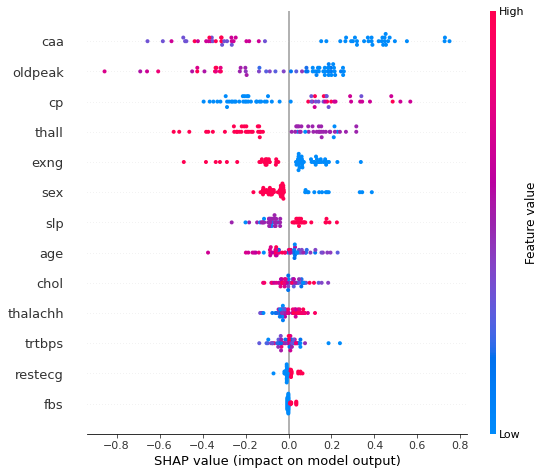

In [118]:
#build tree explainer for xgboost
xgbexplainer = shap.TreeExplainer(xgb,X_train)
xgb_shap_values = xgbexplainer.shap_values(X_test,check_additivity=False)
shap.summary_plot(xgb_shap_values, X_test)

The greater the feature importance, the earlier the separation and nodes. From above shap plot, we can found that 'caa' ,'pldpeak' and 'cp' are top 3 important feature. Higher caa value and oldpeak value can lead less possibility to having heart attck while 'cp' value increase will lead more chance to have heart attack.  And feature 'fbs'(fasting blood sugar > 120 mg/dl) has rarely influence on prediction.<br/>

In [171]:

shap.initjs()
print('output: ',y_test.iloc[2])
shap.force_plot(xgbexplainer.expected_value, xgb_shap_values[2:3], X_test[2:3])#choose and show a single prediction


output:  1


For this person, their prediction is 0.17 (compared to a baseline of -0.01596)and more likely to have heart attack. Biggest impact comes from cp = 2(non-anginal chest pain type) whihc increase the output, and  the caa value =1(i.e. having one major vessel) has a meaningful effect decreasing the prediction. Things like a lower 'oldpeak', a low 'chol', a downsloping 'slp', and having no exercise induced angina('exng') can make person more odds to having heart attack.

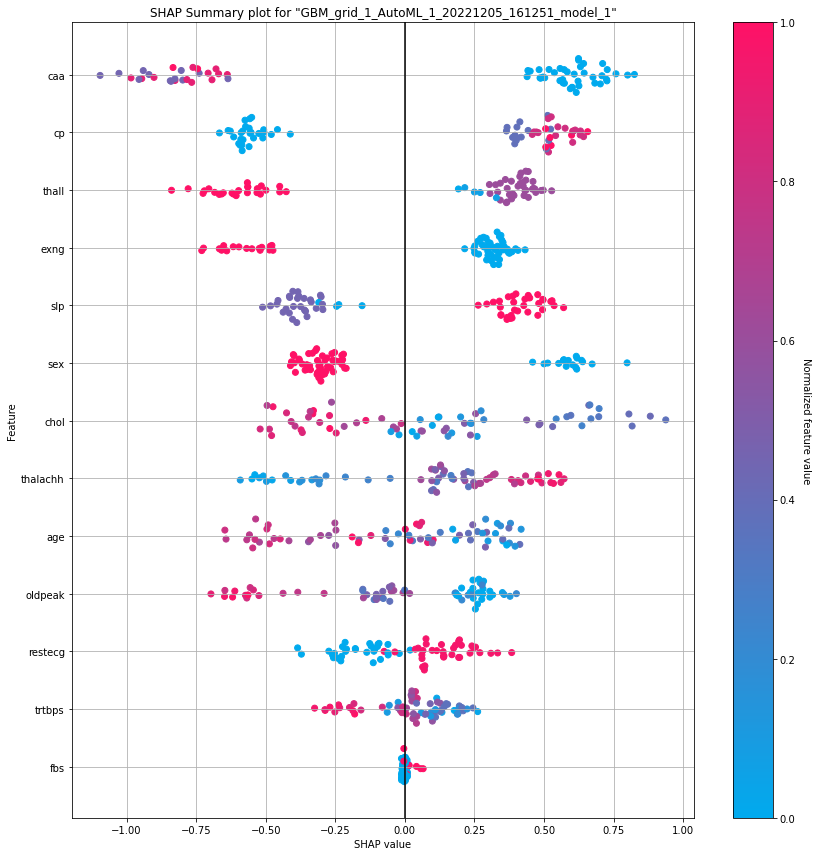

In [38]:
h2olb.shap_summary_plot(test)#directly using h2o automl model's method to show shap plot

Here the 'caa' and 'cp' are top 2 significant variable in this model. higher number of major vessels make person less chance to get heart attack than lower instance. 'cp' value has positive impact on prediction and 'fbs' is barely effect on last shap values.<br>



### Conclusion
In this notebook, logistic regression and xgboost classifier model are trained and interpret with basic interprept method and shap tools. We can find that 'caa' and 'cp' are the top significant features in above 3 models while 'fbs' is hardly impact prediction. Comparing the shap and basic interpret method, the shap summary plot can more directly and more interpretable to show important feature and their influence direction on output/prediction.
### Reference
[1]https://www.kaggle.com/code/tunguz/ieee-with-h2o-automl <br/>
[2]https://www.kaggle.com/code/dansbecker/shap-values <br/>
[3]https://shap.readthedocs.io/en/latest/ <br/>
[4]https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb<br/>
codes refer to [2] and [3], modified parameters for experiments.

### Liciense
Copyright 2022 Yanping Fu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.